# AIPI 590 - XAI | Assignment #6
### Mechanistic Interpretability
### Anish Parmar

This starter notebook was used as the primary reference: https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/assignments/mechanistic_interp_starter.ipynb

The above source is from the class Github repository.

No AI assistance was used to complete this assignment.



[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/anishParmar9778/DukeXAI/blob/main/HW6/AIPI_590_Mechanistic_Interpretability.ipynb)

## **Part 1: 2-Bit XOR Classification Task**

Perform XOR operation on 2 bits (0 or 1)

00 -> 0

01 -> 1

10 -> 1

11 -> 0



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import random

**Generate XOR Train & Test/Val Data**

In [ ]:
def generate_xor_data(n_samples=1000):
    X = np.random.randint(0, 2, size=(n_samples, 2))
    y = np.logical_xor(X[:,0], X[:,1]).astype(int)

    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).unsqueeze(1)

X_train, y_train = generate_xor_data(2000)
X_val, y_val = generate_xor_data(500)

**Build Tiny MLP Model**

In [ ]:
class XORMLP(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=10):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # output single scalar
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        out = self.fc2(h)
        return out, h

model = XORMLP(input_dim=2, hidden_dim=10)
print(model)

XORMLP(
  (fc1): Linear(in_features=2, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=1, bias=True)
)


**Training Loop With Loss**

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

losses = []

for epoch in range(100):
    model.train()
    logits, _ = model(X_train)
    loss = criterion(logits, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

print("Final training loss:", losses[-1])

Final training loss: 0.2981346845626831


**Evaluate on Val/Test Set**

In [ ]:
model.eval()
with torch.no_grad():
    logits, _ = model(X_val)
    preds = (torch.sigmoid(logits) > 0.5).float()
    accuracy = (preds == y_val).float().mean().item()

print(f"Validation Accuracy: {accuracy:.3f}")

Validation Accuracy: 1.000


## **Part 2: Explore**

*Mechanistic Hypothesis:*

The model appears to care about both individual input bits and their logical interactions. Neuron 0 appears to primarily encode the first input bit (highly active when it is 1), while neurons 2 and 7 appears to detect when both bits are active (AND logic operation). The remaining neurons (particularlty 3, 4, 5, 6, 9) appear to encode secondary features and adjust predictions based on specific input combinations to ensure the proper XOR output is set. Together, these neurons form a mechanisitic representation that utilizes both single-bit detectors and smaller interaction detectors, creating a structural basis for the model's XOR classification.

**Print Activations of a Sample Input (0,1)**

In [ ]:
sample_input = torch.tensor([[0,1]], dtype=torch.float32)
with torch.no_grad():
    logits, hidden = model(sample_input)
    pred = torch.sigmoid(logits).item()

print(f"Sample Input: {sample_input}")
print(f"Hidden Layer Activations: {hidden}")
print(f"Output Logit: {logits.item():.3f}, Sigmoid Probability: {pred:.3f}")
print(f"Rounded Prediction: {int(round(pred))}")

Sample Input: tensor([[0., 1.]])
Hidden Layer Activations: tensor([[5.6951e-01, 4.7358e-01, 6.5506e-03, 9.2925e-01, 1.7470e-04, 9.6254e-01,
         3.6996e-01, 6.0778e-03, 0.0000e+00, 9.8517e-01]])
Output Logit: 1.066, Sigmoid Probability: 0.744
Rounded Prediction: 1


**Plot hidden activations across the two possible classes (0 and 1)**

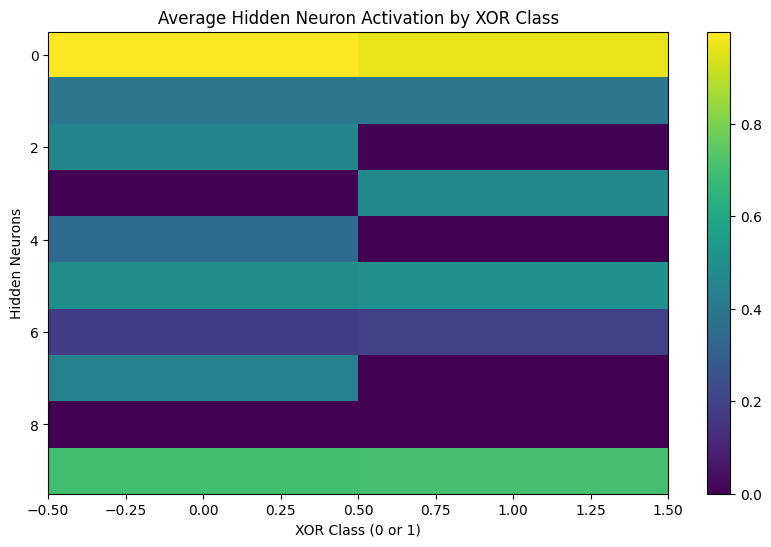

In [ ]:
classes = [0, 1]
average_activations = torch.zeros((2, model.fc1.out_features))

for c in classes:
    class_inputs = X_val[(y_val.squeeze() == c)]
    if class_inputs.shape[0] > 0:
        _, h = model(class_inputs)
        average_activations[c] = h.mean(dim=0)

plt.figure(figsize=(10, 6))
activations_np = average_activations.T.detach().numpy()
plt.imshow(activations_np, aspect='auto', cmap='viridis')
plt.xlabel("XOR Class (0 or 1)")
plt.ylabel("Hidden Neurons")
plt.title("Average Hidden Neuron Activation by XOR Class")
plt.colorbar()
plt.show()

**Plot hidden layer activations for all possible XOR Inputs**

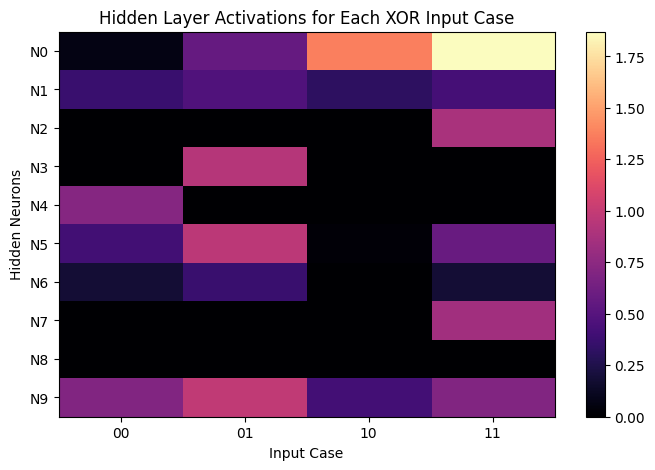

Hidden activations for each input:
[0.0, 0.0] -> [0.06961440294981003, 0.3697647750377655, 0.0, 0.0, 0.7201490998268127, 0.40889495611190796, 0.1857508420944214, 0.0, 0.0, 0.7008859515190125]
[0.0, 1.0] -> [0.5695133209228516, 0.47358331084251404, 0.006550610065460205, 0.9292530417442322, 0.00017470121383666992, 0.962536096572876, 0.369956374168396, 0.006077826023101807, 0.0, 0.9851746559143066]
[1.0, 0.0] -> [1.3699396848678589, 0.3160362243652344, 0.005681097507476807, 0.0, 0.0, 0.02717357873916626, 0.0042696744203567505, 0.0, 0.0, 0.41040506958961487]
[1.0, 1.0] -> [1.8698385953903198, 0.4198547303676605, 0.8801077008247375, 0.0, 0.0, 0.5808147192001343, 0.18847520649433136, 0.843136727809906, 0.0, 0.6946938037872314]


In [ ]:
# activation responses for all 4 possible XOR inputs
xor_inputs = torch.tensor([[0,0],[0,1],[1,0],[1,1]], dtype=torch.float32)
with torch.no_grad():
    _, h = model(xor_inputs)

plt.figure(figsize=(8,5))
plt.imshow(h.numpy().T, aspect='auto', cmap='magma')
plt.yticks(range(model.fc1.out_features), [f"N{i}" for i in range(model.fc1.out_features)])
plt.xticks(range(4), ["00","01","10","11"])
plt.xlabel("Input Case")
plt.ylabel("Hidden Neurons")
plt.title("Hidden Layer Activations for Each XOR Input Case")
plt.colorbar()
plt.show()

print("Hidden activations for each input:")
for i, inp in enumerate(xor_inputs):
    print(inp.tolist(), "->", h[i].tolist())

From this plot, it looks like neuron 0 increases as the first input bit is set (suggests it tracks when the first bit is 1)  while neurons 2 and 7 activates strongly only when both inputs are 1 (suggesting they detect an AND operation). The other neurons (3, 4, 5, 6, 9) display smaller, input-specific responses that likely modulate or refine the model prediction. Neuron 8 does not seem to have any noticeable impact across the 4 input combinations.



**Neuron Ablation (Single Neuron)**

In [ ]:
test_input = torch.tensor([[1,0]], dtype=torch.float32)
true_label = int(np.logical_xor(1,0))

# baseline evaluation (no ablation)
model.eval()
with torch.no_grad():
    baseline_logit, _ = model(test_input)
    baseline_pred = torch.sigmoid(baseline_logit).item()

# ablate neuron 4
neuron_to_zero = 4
with torch.no_grad():
    h = F.relu(model.fc1(test_input))
    h[:, neuron_to_zero] = 0
    modified_logit = model.fc2(h)
    modified_pred = torch.sigmoid(modified_logit).item()

print(f"True Label: {true_label}")
print(f"Baseline Prediction: {baseline_pred:.3f}")
print(f"Prediction with Neuron {neuron_to_zero} Zeroed: {modified_pred:.3f}")

True Label: 1
Baseline Prediction: 0.745
Prediction with Neuron 4 Zeroed: 0.745


The prediction with and without neuron 4 stays the exact same which is expected since the earlier plot indicated that neuron 4 was not being activated for this specific input.

**Neuron Ablation (Sweep of Neurons)**

/tmp/ipython-input-2523254373.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  true_labels = [int(np.logical_xor(x[0], x[1])) for x in test_inputs]


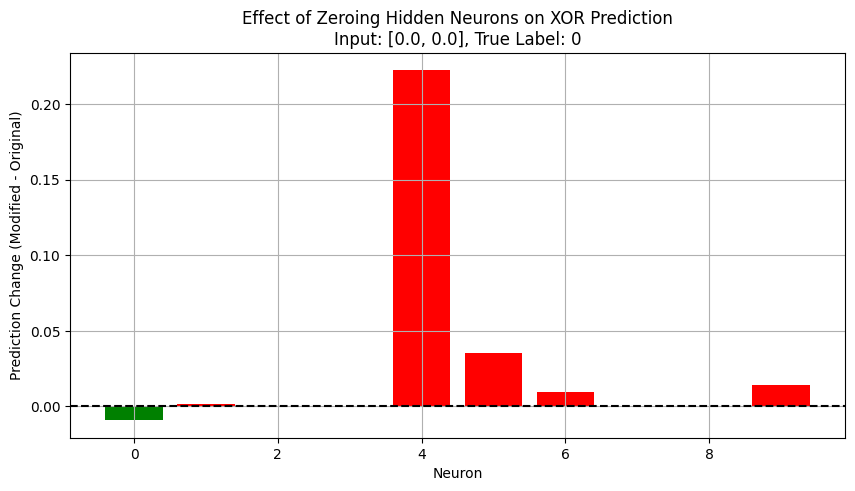

Input: [0.0, 0.0], True Label: 0
Baseline Prediction: 0.259
Neuron 0 → Prediction decreased by 0.009
Neuron 1 → Prediction increased by 0.002
Neuron 4 → Prediction increased by 0.222
Neuron 5 → Prediction increased by 0.035
Neuron 6 → Prediction increased by 0.010
Neuron 9 → Prediction increased by 0.014

--------------------------------------------------



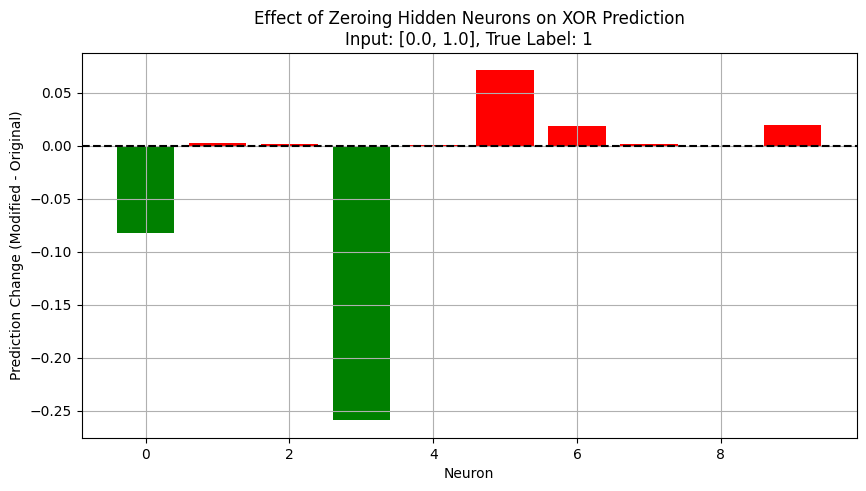

Input: [0.0, 1.0], True Label: 1
Baseline Prediction: 0.744
Neuron 0 → Prediction decreased by 0.083
Neuron 1 → Prediction increased by 0.002
Neuron 2 → Prediction increased by 0.002
Neuron 3 → Prediction decreased by 0.259
Neuron 5 → Prediction increased by 0.071
Neuron 6 → Prediction increased by 0.018
Neuron 7 → Prediction increased by 0.001
Neuron 9 → Prediction increased by 0.019

--------------------------------------------------



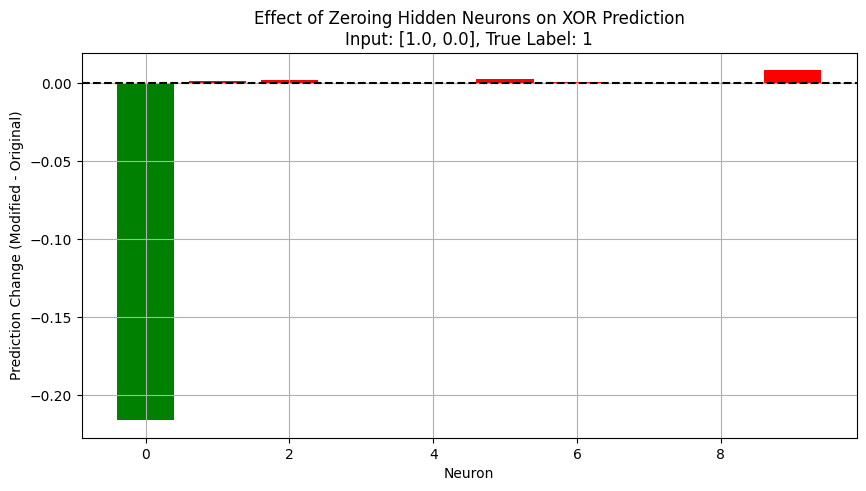

Input: [1.0, 0.0], True Label: 1
Baseline Prediction: 0.745
Neuron 0 → Prediction decreased by 0.216
Neuron 1 → Prediction increased by 0.001
Neuron 2 → Prediction increased by 0.002
Neuron 5 → Prediction increased by 0.002
Neuron 9 → Prediction increased by 0.008

--------------------------------------------------



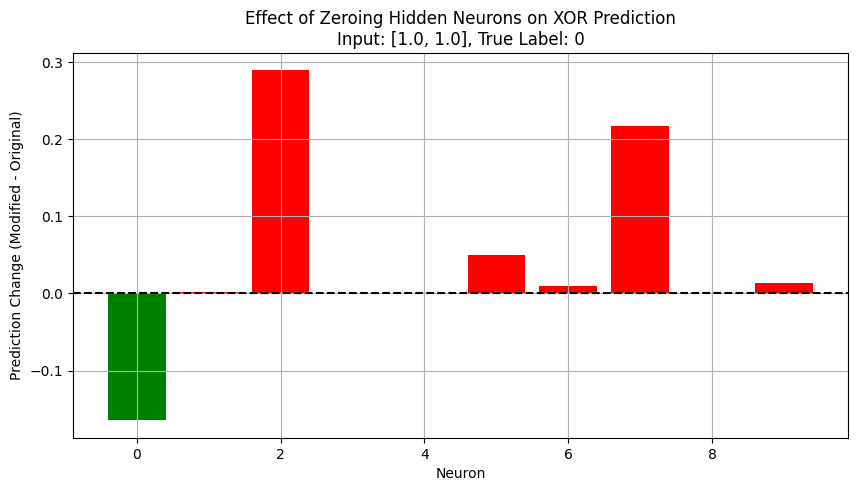

Input: [1.0, 1.0], True Label: 0
Baseline Prediction: 0.245
Neuron 0 → Prediction decreased by 0.164
Neuron 1 → Prediction increased by 0.002
Neuron 2 → Prediction increased by 0.289
Neuron 5 → Prediction increased by 0.049
Neuron 6 → Prediction increased by 0.009
Neuron 7 → Prediction increased by 0.217
Neuron 9 → Prediction increased by 0.014

--------------------------------------------------



In [ ]:
# all 4 XOR inputs
test_inputs = torch.tensor([[0,0],[0,1],[1,0],[1,1]], dtype=torch.float32)
true_labels = [int(np.logical_xor(x[0], x[1])) for x in test_inputs]

model.eval()

for index, test_input in enumerate(test_inputs):
    test_input_batch = test_input.unsqueeze(0)

    # baseline evaluation (no ablation)
    with torch.no_grad():
        baseline_logit, _ = model(test_input_batch)
        baseline_pred = torch.sigmoid(baseline_logit).item()

    # neuron ablation
    neuron_indices = list(range(model.fc1.out_features))
    signed_deltas = []

    for i in neuron_indices:
        with torch.no_grad():
            h = F.relu(model.fc1(test_input_batch))
            h[:, i] = 0
            modified_logit = model.fc2(h)
            modified_pred = torch.sigmoid(modified_logit).item()
            signed_deltas.append(modified_pred - baseline_pred)

    plt.figure(figsize=(10,5))
    colors = ['green' if delta < 0 else 'red' if delta > 0 else 'gray' for delta in signed_deltas]
    plt.bar(neuron_indices, signed_deltas, color=colors)
    plt.axhline(0, color='black', linestyle='--')
    plt.xlabel("Neuron")
    plt.ylabel("Prediction Change (Modified - Original)")
    plt.title(f"Effect of Zeroing Hidden Neurons on XOR Prediction\nInput: {test_input.tolist()}, True Label: {true_labels[index]}")
    plt.grid(True)
    plt.show()

    print(f"Input: {test_input.tolist()}, True Label: {true_labels[index]}")
    print(f"Baseline Prediction: {baseline_pred:.3f}")
    for i, delta in enumerate(signed_deltas):
        if abs(delta) > 1e-3:
            direction = "increased" if delta > 0 else "decreased"
            print(f"Neuron {i} → Prediction {direction} by {abs(delta):.3f}")
    print("\n" + "-"*50 + "\n")


Zeroing individual neurons allows us to see their impact on predictions across all 4 XOR inputs. Neuron 0 appears to have a very strong effect, especially when the first bit is 1. When it is removed, the prediction is consistently decreased (brought closer to XOR = 0). Neuron 2 is mostly impactful when the input is 1,1. This suggests that it may encode the interaction of ANDing both of the bits. The other neurons show much smaller yet possibly still meaningful effects depending on the particular combination of inputs. They likely provide corrective signals to the output (increase or decrease).  

## **Part 3: Explain**

The analysis of the hidden layer from part 2 reveals a clearly structured and interpretable representation of XOR logic. Neuron 0 consistently tracks the first input bit (strongly influencing the predictions when the first input bit is set to 1) while Neuron 2 and Neuron 7 activate primarily when both inputs are 1 (effectively representing an AND operation). Other neurons (3, 4, 5, 6, 9) contribute smaller, modulatory effects by adjusting predictions for specific input patterns to refine the XOR computation. 

![Hidden_Layer_Activations](Hidden_Layer_Activations.png)

The ablation experiments below from part 2 confirm these roles by showing that zeroing a neuron decreases or increases predictions in ways that align with the feature it encodes. Zeroing neuron 0 appears to have a very strong effect as the prediction is consistently decreased (brought closer to XOR = 0). Zeroing neuron 0 also seems to have the largest effect when the first input bit is 1 (similar to our thinking from the hidden layer activations above). Zeroing neuron 2 and/or neuron 7 only has a significant impact on the prediction when the input is 1,1. This supports the idea seen earlier that it may encode the interaction of ANDing both of the bits. 

![0_0](0_0.png)
![0_1](0_1.png)
![1_0](1_0.png)
![1_1](1_1.png)

This combination of activation patterns and ablation results provides us with a clear mechanistic picture where the model decomposes XOR computation into interpretable components, with primary neurons detecting input bits and key interactions, and other neurons fine-tuning the output.

Think of it similar to an oversized group project. If you have a team of 10 people and the task is relatively small, it is possible that 3 people will end up doing 3 major tasks in the project. The remaining 7 people may either do no significant work at all or provide smaller contributions (proofreading, polishing, citing sourcesm, etc.) that are still meaningful are impact the final project submission (not as influential yet still important).

## **Part 4: Reflect**

Through this in-depth analysis, I learned that the model's hidden layer implements XOR classification via a combination of primary feature detecting neurons and secondary supportive neurons. While some neurons like 0, 2 and 7 have clearly interpetable roles (easy to map to a particular combination/trend in inputs), the remaining neurons contribute more subtle, input-specific adjustments that are more difficult to easily interpret. I also learned how to ablate neurons across possible inputs. It is a powerful technique that allows you to observe the individual impact of each neuron on the prediction for each input combination (sort of similiar to the idea behind SHAP).

I was surprised by how the model relies on so many other neurons to fine-tune predictions (slightly influence them) even when solving a relatively simple XOR function. I also did notice that when I re-initialized the model and repeated the analysis (re-ran the cells), different neurons become active and their impact/roles change. This potentially indicates that a neural network can learn the same task (XOR function) using different internal feature assignments across runs (especially since there may be more neurons than necessary).


One area that I would like to further explore and understand better is how these secondary neurons interact with one another and with the primary neurons to shape the final produced output. Trying out this analysis approach in the case of deeper networks or more complex logical functions/tasks/inputs could reveal whether similar relationships are present at larger scales.
